# RL Policy Training - DQN

Train DQN (discrete actions) to learn service policies and compare against baselines.

**Optional variance reduction:** If `discretiser-surrogate` is installed, can use `MultiSampleServiceEnv` which samples multiple failure outcomes per step, reducing gradient variance by O(1/n).

See also:
- `rl_quickstart.ipynb` - Minimal example (runnable by anyone)
- `rl_sac.ipynb` - SAC with continuous action space

In [ ]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from src.rl import (
    ServiceEnv,
    get_default_scenario,
    print_scenario_info,
    compare_with_baselines,
    run_sanity_check,
    evaluate_model,
    print_evaluation_results,
    format_stats,
    RewardLoggerCallback,
    EpisodeDiagnosticsCallback,
    ActionStatsCallback,
    DEFAULT_MAX_TIME,
)

# Optional: variance-reduced environment from discretiser-surrogate
try:
    from discretiser_surrogate import MultiSampleServiceEnv, SurvivalFractionCallback
    HAS_SURROGATE = True
    print("discretiser-surrogate available: MultiSampleServiceEnv, SurvivalFractionCallback")
except ImportError:
    HAS_SURROGATE = False
    print("discretiser-surrogate not installed, using standard ServiceEnv")

## 1. Setup Scenario

In [ ]:
# Use shared scenario setup
scenario = get_default_scenario()
print_scenario_info(scenario)

MAX_TIME = DEFAULT_MAX_TIME

# ============================================================
# KEY CONFIG
# ============================================================
FIXED_DURABILITY = None  # None = variable, 1.0 = fixed for debugging
ACTION_STEP = 2.0        # Discrete action step size

# Evaluation settings (aligned across all eval methods for comparable error bars)
N_EVAL_EPISODES = 5000   # For RL eval and sanity check
N_BASELINE_REPEATS = 500 # For baseline comparison (each repeat = 2000 subjects)

# Variance reduction via multi-sample environment (requires discretiser-surrogate)
USE_VARIANCE_REDUCTION = HAS_SURROGATE and True  # Set to False to disable even if available
N_SAMPLES = 10  # Number of failure samples per step (only if USE_VARIANCE_REDUCTION)

print(f"\nDurability config: {'FIXED at ' + str(FIXED_DURABILITY) if FIXED_DURABILITY else 'VARIABLE'}")
print(f"Variance reduction: {'ENABLED (n_samples={N_SAMPLES})' if USE_VARIANCE_REDUCTION else 'DISABLED'}")

## 2. Baseline Comparison

First, establish baseline performance with known policies.

In [ ]:
# Compare baseline policies (always uses variable durability)
results = compare_with_baselines(scenario, max_time=MAX_TIME, n_repeats=N_BASELINE_REPEATS)

if FIXED_DURABILITY is not None:
    print(f"\nNote: Baselines above use variable durability.")
    print(f"      Training uses fixed durability={FIXED_DURABILITY} - see sanity check for proper baseline.")

In [ ]:
# Sanity check: Run optimal policy through RL environment
# Uses same FIXED_DURABILITY as training config
sanity_results = run_sanity_check(scenario, max_time=MAX_TIME, fixed_durability=FIXED_DURABILITY, n_episodes=N_EVAL_EPISODES)

if FIXED_DURABILITY is None:
    print(f"\nExpected: Should match 'optimised_linear' baseline (~{results['optimised_linear']['mean']:.2f})")
else:
    print(f"\nThis is the proper baseline for fixed_durability={FIXED_DURABILITY}")

## 3. Train DQN

In [ ]:
# Train DQN
import torch.nn as nn
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback

# Environment settings (FIXED_DURABILITY and ACTION_STEP defined in cell 3)
REWARD_SCALE = None      # None = use failure_cost (rewards in ~[0, 2.5])

# DQN hyperparameters
LEARNING_RATE = 1e-4     # Try lower (1e-4, 5e-5) if unstable
BATCH_SIZE = 16*256      # Try larger (512, 1024) for stability
GAMMA = 0.99

# Exploration
EXPLORATION_FRACTION = 0.3
EXPLORATION_FINAL_EPS = 0.05

# Target network updates - two options:
# 1. Hard updates: tau=1.0, target_update_interval=N (replace every N steps)
# 2. Soft updates: tau=0.005, target_update_interval=1 (Polyak averaging each step)
# The most promising result was with hard updates at interval=2000
TAU = 0.0002             # Polyak averaging coefficient (1.0 = hard update)
TARGET_UPDATE_INTERVAL = 1  # Try 2000 for stability (default 1000)

# Gradient clipping for stability (None to disable)
MAX_GRAD_NORM = 2.0      # Try 1.0 or 5.0 if loss explodes (default 10)

# Checkpointing
SAVE_CHECKPOINTS = True
CHECKPOINT_FREQ = 10_000  # Save model every N steps

# Create training environment
if USE_VARIANCE_REDUCTION:
    # Variance-reduced environment (multi-sample) with discrete actions
    env = MultiSampleServiceEnv(
        scenario,
        n_samples=N_SAMPLES,
        max_time=MAX_TIME,
        seed=42,
        action_step=ACTION_STEP,
        fixed_durability=FIXED_DURABILITY,
        continuous_actions=False,  # DQN uses discrete actions
    )
    print(f"Using MultiSampleServiceEnv with n_samples={N_SAMPLES}, discrete actions")
else:
    # Standard environment
    env = ServiceEnv(
        scenario, 
        max_time=MAX_TIME, 
        seed=42,
        reward_scale=REWARD_SCALE,
        action_step=ACTION_STEP,
        fixed_durability=FIXED_DURABILITY,
    )
    print("Using standard ServiceEnv")

# Store action_delays before wrapping (Monitor hides attributes)
trained_action_delays = env.action_delays
print(f"Action space: {len(trained_action_delays)} actions (step={ACTION_STEP})")
print(f"Delays: {trained_action_delays[:5]} ... {trained_action_delays[-3:]}")
print(f"Reward scale: {env.reward_scale}")
print(f"Fixed durability: {FIXED_DURABILITY}")

# Optimal interval for durability=1.0: 24.2 + 24.2*1.0 = 48.4
if FIXED_DURABILITY is not None:
    opt_interval = 24.2 + 24.2 * FIXED_DURABILITY
    print(f"Optimal interval (from linear policy): {opt_interval:.1f}")
else:
    print("Optimal interval varies: 24.2 + 24.2 * durability")

# Create evaluation environments (always use standard env for fair comparison)
eval_env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=123,
    action_step=ACTION_STEP, fixed_durability=FIXED_DURABILITY,
)
optimal_env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=123,
    action_step=ACTION_STEP, fixed_durability=FIXED_DURABILITY,
    use_optimal_policy=True,  # Uses optimal linear policy, ignores actions
)

# Wrap training env for logging
env = Monitor(env)

# Network architecture
# Note: SB3 DQN does not support dueling architecture
policy_kwargs = dict(
    net_arch=[64, 64],
    activation_fn=nn.Tanh, # nn.ReLU,
)

# Print configuration
print(f"\nDQN Configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Target updates: tau={TAU}, interval={TARGET_UPDATE_INTERVAL}")
print(f"  Gradient clipping: max_grad_norm={MAX_GRAD_NORM}")
print(f"  Network: {policy_kwargs}")

# TensorBoard: run `tensorboard --logdir ./logs` to watch
print("\nTraining DQN (verbose=0, use TensorBoard to monitor)...")

model = DQN(
    'MlpPolicy',
    env,
    learning_rate=LEARNING_RATE,
    buffer_size=50_000,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    exploration_fraction=EXPLORATION_FRACTION,
    exploration_final_eps=EXPLORATION_FINAL_EPS,
    tau=TAU,
    target_update_interval=TARGET_UPDATE_INTERVAL,
    max_grad_norm=MAX_GRAD_NORM,
    policy_kwargs=policy_kwargs,
    verbose=0,  # Suppress output (use TensorBoard instead)
    seed=42,
    tensorboard_log="./logs",
)

# Callbacks for logging (from src.rl.callbacks)
reward_logger = RewardLoggerCallback()
callbacks = [
    reward_logger,
    ActionStatsCallback(trained_action_delays, log_freq=1000),
    EpisodeDiagnosticsCallback(
        max_time=MAX_TIME,
        log_freq=100,
        eval_env=eval_env,
        optimal_env=optimal_env,
        n_eval_episodes=50,
    ),
]

# Add survival fraction callback if using variance reduction
if USE_VARIANCE_REDUCTION:
    callbacks.append(SurvivalFractionCallback(log_freq=100))
    print("  Added SurvivalFractionCallback for variance reduction monitoring")

# Optional: Save checkpoints during training
if SAVE_CHECKPOINTS:
    checkpoint_callback = CheckpointCallback(
        save_freq=CHECKPOINT_FREQ,
        save_path='./checkpoints/',
        name_prefix='dqn_service',
    )
    callbacks.append(checkpoint_callback)
    print(f"  Checkpoints: every {CHECKPOINT_FREQ} steps to ./checkpoints/")

model.learn(total_timesteps=200_000, callback=callbacks)

# Store for later cells
training_rewards = reward_logger.episode_rewards
trained_model = model

print(f"\nTraining complete!")
print(f"Episodes: {len(training_rewards)}")

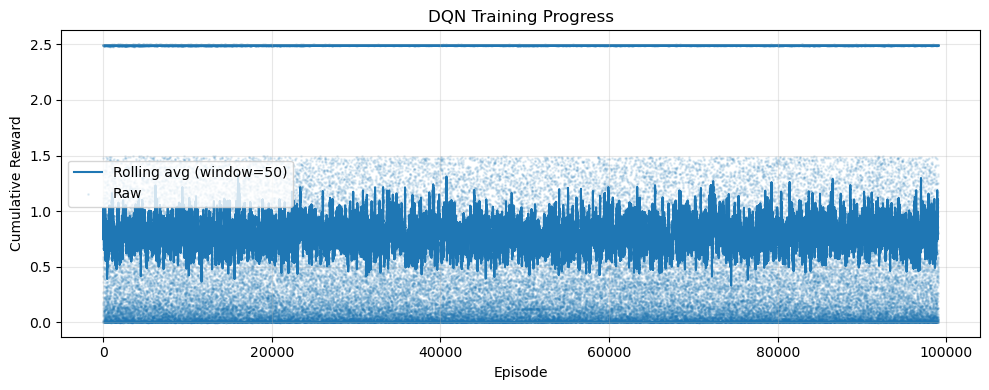

In [6]:
# Plot training progress
fig, ax = plt.subplots(figsize=(10, 4))

# Smooth rewards with rolling average
rewards = training_rewards  # From previous cell
window = 50
if len(rewards) > window:
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax.plot(smoothed, label=f'Rolling avg (window={window})')
    ax.scatter(range(len(rewards)), rewards, alpha=0.1, s=1, label='Raw')
else:
    ax.plot(rewards)

ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Reward')
ax.set_title('DQN Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Evaluate Trained Model

In [ ]:
# Evaluate trained model (uses original metric for comparison with baselines)
dqn_results = evaluate_model(
    trained_model,
    scenario,
    n_episodes=N_EVAL_EPISODES,
    max_time=MAX_TIME,
    seed=42,
    deterministic=True,
    action_step=ACTION_STEP,
    fixed_durability=FIXED_DURABILITY,
)

print_evaluation_results(dqn_results, "DQN", show_minmax=True)

In [ ]:
# Compare DQN vs baselines with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# === Left plot: Rewards ===
ax = axes[0]

# Collect means and SEMs for all methods
all_data = []
for name, stats in results.items():
    # Baseline std is already std of batch means ≈ SEM
    all_data.append({'name': name, 'mean': stats['mean'], 'sem': stats['std'], 'type': 'baseline'})

# DQN: compute SEM from episode rewards
dqn_rewards = dqn_results['rewards']
dqn_sem = np.std(dqn_rewards) / np.sqrt(len(dqn_rewards))
all_data.append({'name': 'DQN', 'mean': np.mean(dqn_rewards), 'sem': dqn_sem, 'type': 'rl'})

# Sanity check (optimal with same durability)
if FIXED_DURABILITY is not None:
    sanity_rewards = sanity_results['rewards']
    sanity_sem = np.std(sanity_rewards) / np.sqrt(len(sanity_rewards))
    all_data.append({'name': 'optimal (fixed d)', 'mean': np.mean(sanity_rewards), 'sem': sanity_sem, 'type': 'optimal'})

# Sort by mean
all_data = sorted(all_data, key=lambda x: x['mean'])
names = [d['name'] for d in all_data]
means = [d['mean'] for d in all_data]
sems = [d['sem'] for d in all_data]
colors = ['green' if d['type'] == 'rl' else 'orange' if d['type'] == 'optimal' else 'steelblue' for d in all_data]

# Plot with error bars
bars = ax.barh(names, means, xerr=sems, color=colors, capsize=3)

ax.set_xlabel('Mean Reward (± SEM)')
title = 'DQN vs Baselines'
if FIXED_DURABILITY is not None:
    title += f' (fixed durability={FIXED_DURABILITY})'
ax.set_title(title)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (mean, sem) in enumerate(zip(means, sems)):
    ax.text(mean + sem + 2, i, f'{mean:.1f}±{sem:.1f}', va='center', fontsize=8)

# === Right plot: Episode Times (RL methods only) ===
ax = axes[1]

time_data = []
# DQN times
dqn_times = dqn_results['times']
dqn_time_sem = np.std(dqn_times) / np.sqrt(len(dqn_times))
time_data.append({'name': 'DQN', 'mean': np.mean(dqn_times), 'sem': dqn_time_sem, 'type': 'rl'})

# Optimal times (sanity check)
sanity_times = sanity_results['times']
sanity_time_sem = np.std(sanity_times) / np.sqrt(len(sanity_times))
time_data.append({'name': 'optimal', 'mean': np.mean(sanity_times), 'sem': sanity_time_sem, 'type': 'optimal'})

# Sort by mean time
time_data = sorted(time_data, key=lambda x: x['mean'])
time_names = [d['name'] for d in time_data]
time_means = [d['mean'] for d in time_data]
time_sems = [d['sem'] for d in time_data]
time_colors = ['green' if d['type'] == 'rl' else 'orange' if d['type'] == 'optimal' else 'steelblue' for d in time_data]

# Plot with error bars
bars = ax.barh(time_names, time_means, xerr=time_sems, color=time_colors, capsize=3)

ax.set_xlabel('Mean Episode Time (± SEM)')
ax.set_title('Episode Duration (RL methods)')
ax.axvline(x=MAX_TIME, color='red', linestyle='--', alpha=0.5, label=f'max_time={MAX_TIME}')
ax.legend()

# Add value labels
for i, (mean, sem) in enumerate(zip(time_means, time_sems)):
    ax.text(mean + sem + 2, i, f'{mean:.1f}±{sem:.1f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

if FIXED_DURABILITY is not None:
    print(f"\nNote: 'optimal (fixed d)' uses same fixed_durability={FIXED_DURABILITY} as DQN.")
    print(f"      Other baselines use variable durability (not directly comparable).")

# Diagnostic: Run a few episodes manually
print("\n--- Diagnostic: Episode traces ---")
print("Obs (normalised): [time, last_int, svc_cnt, avg_int, dur] - shown denormalised below")
env = ServiceEnv(scenario, max_time=MAX_TIME, seed=123, action_step=ACTION_STEP, fixed_durability=FIXED_DURABILITY)
for ep in range(3):
    obs, info = env.reset(seed=123 + ep)
    print(f"\nEpisode {ep+1}: durability={obs[4]*10:.2f}")
    total_reward = 0
    step = 0
    while True:
        action, _ = trained_model.predict(obs, deterministic=True)
        delay = trained_action_delays[int(action)]
        obs, reward, term, trunc, info = env.step(action)
        total_reward += reward
        step += 1
        if step <= 5:
            t = obs[0] * MAX_TIME
            last_int = obs[1] * MAX_TIME
            print(f"  step {step}: t={t:5.1f}, last_int={last_int:5.1f}, action={int(action)} (delay={delay:4.0f}), reward={reward:7.2f}")
        if term or trunc:
            status = "FAILED" if term else "TRUNCATED"
            print(f"  ... {status} at t={info['time']:.1f}, services={info['service_count']}, total_orig={info['cumulative_reward_original']:.1f}")
            break

## 5. Analyse DQN Behaviour

In [ ]:
# Analyse action distribution across different states
import pandas as pd

env = ServiceEnv(scenario, max_time=MAX_TIME, seed=42, action_step=ACTION_STEP, fixed_durability=FIXED_DURABILITY)

# Collect state -> action pairs
state_actions = []
for ep in range(100):
    obs, _ = env.reset(seed=42 + ep)
    done = False
    while not done:
        action, _ = trained_model.predict(obs, deterministic=True)
        state_actions.append({
            'current_time': obs[0] * MAX_TIME,      # denormalise
            'last_interval': obs[1] * MAX_TIME,
            'service_count': obs[2] * 100,
            'avg_interval': obs[3] * MAX_TIME,
            'durability': obs[4] * 10,
            'action': int(action),
            'delay': trained_action_delays[int(action)]
        })
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

df = pd.DataFrame(state_actions)

print("Action distribution:")
print(df['delay'].value_counts().sort_index())
print(f"\nTotal decisions: {len(df)}")

if FIXED_DURABILITY is not None:
    print(f"\nOptimal delay for durability={FIXED_DURABILITY}: {24.2 + 24.2 * FIXED_DURABILITY:.1f}")
else:
    print("\nOptimal delay varies: 24.2 + 24.2 * durability")

In [ ]:
# Plot action choices
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Action vs last_interval (colored by durability)
ax = axes[0]
scatter = ax.scatter(df['last_interval'], df['delay'], c=df['durability'], 
                     alpha=0.5, s=20, cmap='viridis')
ax.set_xlabel('Last Interval')
ax.set_ylabel('Chosen Delay')
ax.set_title('Action vs Last Interval')
plt.colorbar(scatter, ax=ax, label='Durability')

# Middle plot depends on durability config
ax = axes[1]
if FIXED_DURABILITY is not None:
    # With fixed durability, show delay vs service_count
    ax.scatter(df['service_count'], df['delay'], alpha=0.5, s=20)
    ax.axhline(24.2 + 24.2 * FIXED_DURABILITY, color='red', linestyle='--', label='Optimal')
    ax.set_xlabel('Service Count')
    ax.set_ylabel('Chosen Delay')
    ax.set_title(f'Delay vs Service Count (durability={FIXED_DURABILITY})')
    ax.legend()
else:
    # With variable durability, show delay vs durability
    for action_idx in range(len(trained_action_delays)):
        mask = df['action'] == action_idx
        if mask.any():
            delay = trained_action_delays[action_idx]
            label = f'delay={delay}' if delay < float('inf') else 'no service'
            ax.scatter(df.loc[mask, 'durability'], df.loc[mask, 'last_interval'],
                       alpha=0.3, s=10, label=label)
    ax.set_xlabel('Durability')
    ax.set_ylabel('Last Interval')
    ax.set_title('Action by Durability & Last Interval')
    if len(trained_action_delays) <= 10:
        ax.legend(markerscale=3, fontsize=8)

# Average delay vs durability bins (only meaningful with variable durability)
ax = axes[2]
if FIXED_DURABILITY is not None:
    # Show delay over time instead
    ax.scatter(df['current_time'], df['delay'], c=df['service_count'], alpha=0.5, s=20, cmap='viridis')
    ax.axhline(24.2 + 24.2 * FIXED_DURABILITY, color='red', linestyle='--', label='Optimal')
    ax.set_xlabel('Current Time')
    ax.set_ylabel('Chosen Delay')
    ax.set_title('Delay vs Time')
    ax.legend()
else:
    df['durability_bin'] = pd.cut(df['durability'], bins=8)
    finite_delays = df[df['delay'] < float('inf')]
    if len(finite_delays) > 0:
        avg_delay = finite_delays.groupby('durability_bin', observed=True)['delay'].mean()
        avg_delay.plot(kind='bar', ax=ax, color='steelblue')
        ax.set_xlabel('Durability Bin')
        ax.set_ylabel('Average Delay')
        ax.set_title('Avg Delay by Durability')
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# What interval does optimal linear use?
print("\nOptimal linear policy intervals for reference:")
print("  interval = 24.2 + 24.2 * durability")
for d in [0.7, 1.0, 1.3, 1.6]:
    print(f"  durability={d:.1f} -> interval={24.2 + 24.2*d:.1f}")

## 6. Save Model

In [11]:
# Save trained model
model_path = '../models/dqn_service_policy'
trained_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/dqn_service_policy
